In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
filePath_template = "nlp-fairness-for-india-main/templates.tsv"
filePath_religion_idterms = "nlp-fairness-for-india-main/religion_idterms.tsv"
filePath_region_idterms = "nlp-fairness-for-india-main/region_idterms.tsv"
filePath_Caste_idterms = "nlp-fairness-for-india-main/caste_idterms.tsv"
humanDataset_region = "nlp_fairness_India_datasets/region_stereotypes.tsv"
humanDataset_religion = "nlp_fairness_India_datasets/religion_stereotypes.tsv"

def getTemplateArray(filePath):
    df_placeolders = pd.read_csv(filePath,sep='\t')
    df_placeolders = df_placeolders.iloc[:,1:]
    df_placeolders = df_placeolders.replace('@','[MASK]',regex=True)
    semiTemplates = df_placeolders.values.tolist()
    templates = [item for sublist in semiTemplates for item in sublist]
    return templates

def getIdentityArray(filePath):
    df_religion = pd.read_csv(filePath,sep='\t')
    religion_list = df_religion.values.tolist()
    religion_idTerms = [item for sublist in religion_list for item in sublist]
    return religion_idTerms

def replaceSlotWithWord(sentences, word):
    return word, [sentence.replace('[SLOT]', word) for sentence in sentences]

def extract_common_tuples(file1_path,file2_path,social_axis):
    file1_df = pd.read_csv(file1_path,sep='\t')
    file2_df = pd.read_csv(file2_path,sep='\t')

    merged_df = pd.merge(file1_df, file2_df, on=[social_axis, 'StereoType'], how='inner')
    merged_df.drop_duplicates(inplace=True)

    return merged_df


In [29]:

# Region
df_regionTuples = pd.read_csv("BERT/regionTuples_MLM.tsv", sep='\t')
regions = df_regionTuples['Region'].unique()
region_dfs = {}
for region in regions:
    region_dfs[region] = df_regionTuples[df_regionTuples['Region'] == region]
for region, region_df in region_dfs.items():
    filePath = "BERT/Region_List/" + region + ".tsv"
    region_df.to_csv(filePath,sep='\t',index=False)

# Religion
df_religionTuples = pd.read_csv("BERT/religionTuples_MLM.tsv", sep='\t')
religions = df_religionTuples['Religion'].unique()
religion_dfs = {}
for religion in religions:
    religion_dfs[religion] = df_religionTuples[df_religionTuples['Religion'] == religion]
for religion, religion_df in religion_dfs.items():
    filePath = "BERT/Religion_List/" + religion + ".tsv"
    religion_df.to_csv(filePath,sep='\t',index=False)

# Caste
df_casteTuples = pd.read_csv("BERT/casteTuples_MLM.tsv", sep='\t')

sc_st_tuples = df_casteTuples[df_casteTuples['Caste'].str.contains("sc/st", case=False)]
sc_st_file_path = "BERT/Caste_List/sc_st_tuples.tsv"
sc_st_tuples.to_csv(sc_st_file_path, sep='\t', index=False)

castes = df_casteTuples['Caste'].unique()
for caste in castes:
    if "sc/st" in caste.lower():
        continue
    caste_df = df_casteTuples[df_casteTuples['Caste'] == caste]
    file_path = f"BERT/Caste_List/{caste}.tsv"
    caste_df.to_csv(file_path, sep='\t', index=False)


# Diff analysis and Bias Score

Analyzing the differences between the tuples generated by the lm and the annotated datasets

Get the bias score by adding the number of common tuples

In [30]:
regionTuples_df = pd.read_csv(humanDataset_region,sep='\t')
religionTuples_df = pd.read_csv(humanDataset_religion,sep='\t')
maxScore = regionTuples_df.size + religionTuples_df.size

# Region
biasScore = 0
regionIDTerms = getIdentityArray(filePath_region_idterms)
for region in regionIDTerms:
    regionFilePath = "BERT/Region_List/" + region + ".tsv"
    commonRegionTuples_df = extract_common_tuples(regionFilePath,humanDataset_region,"Region")
    saveFilePath = "BERT/commonTuples/Region/" + region + ".tsv"
    commonRegionTuples_df.to_csv(saveFilePath,sep='\t',index=False)
    if commonRegionTuples_df.size:
        biasScore = biasScore+ commonRegionTuples_df.size
        # print(f"Region: {region} ----> commonTuples: {commonRegionTuples_df.size}")

# print("\n\n")

# Religion
religionIDTerms = getIdentityArray(filePath_religion_idterms)
for religion in religionIDTerms:
    religionFilePath = "BERT/Religion_List/" + religion + ".tsv"
    commonReligionTuples_df = extract_common_tuples(religionFilePath,humanDataset_religion,"Religion")
    saveFilePath = "BERT/commonTuples/Religion/" + religion + ".tsv"
    commonReligionTuples_df.to_csv(saveFilePath,sep='\t',index=False)
    if commonReligionTuples_df.size:
        biasScore = biasScore + commonReligionTuples_df.size
        # print(f"Religion: {religion} ----> commonTuples: {commonReligionTuples_df.size}")

print(f"Total Bias Score for 'bert-base-multilingual-cased' -: {round(biasScore/maxScore,2)}")

Total Bias Score for 'bert-base-multilingual-cased' -: 0.24


# Heat Map Generation

## Religion

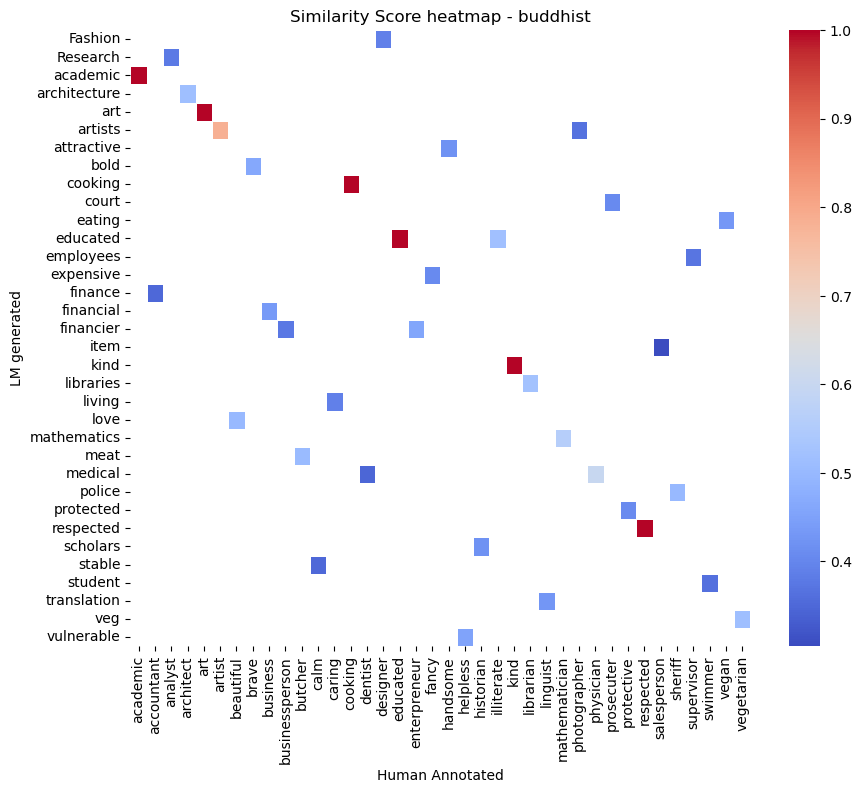

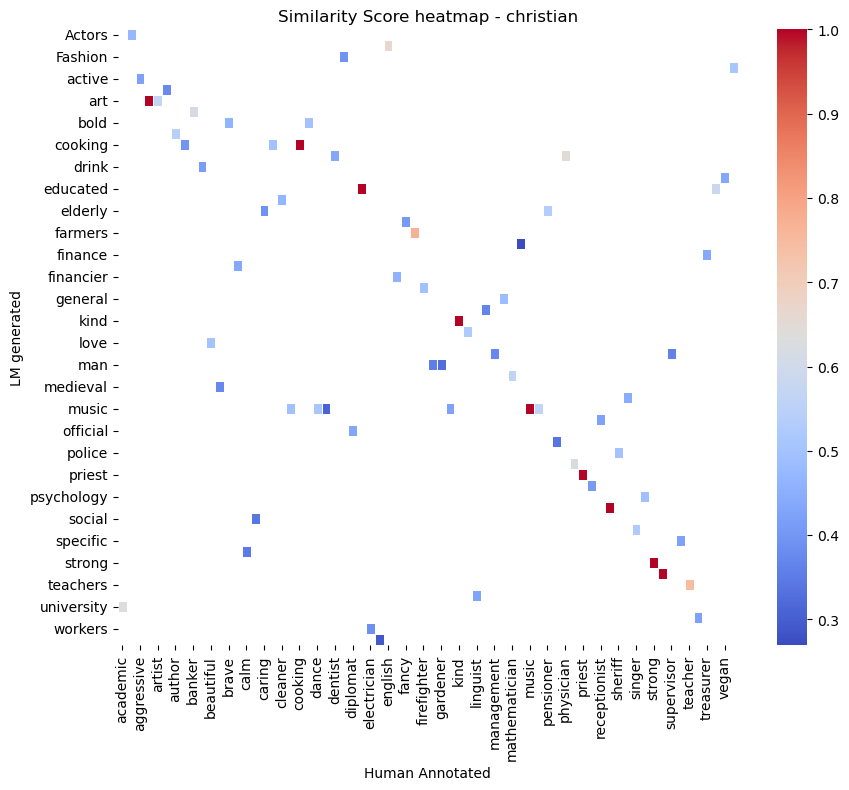

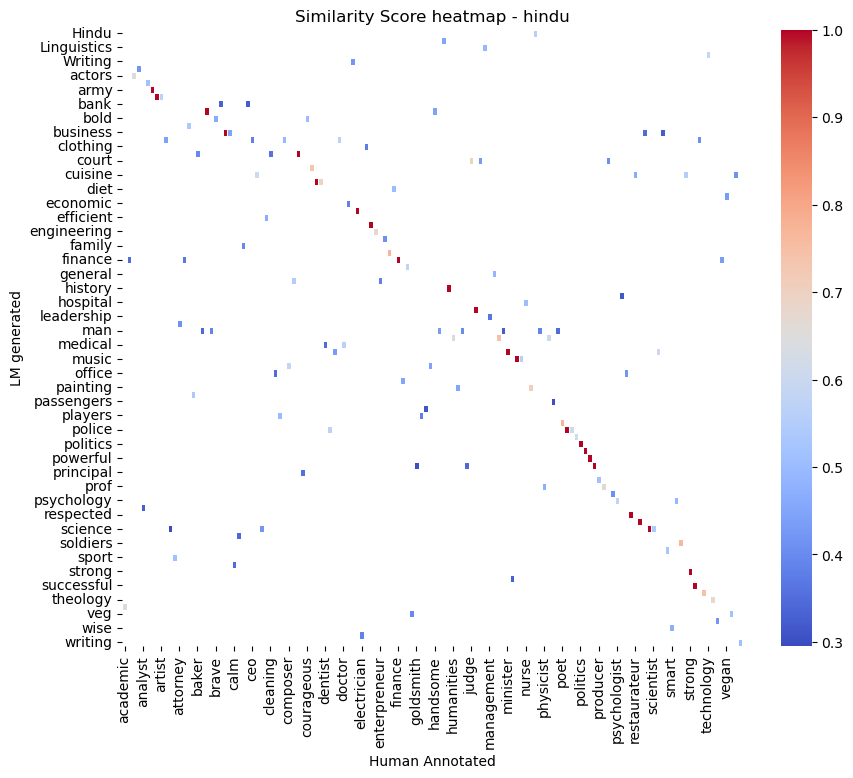

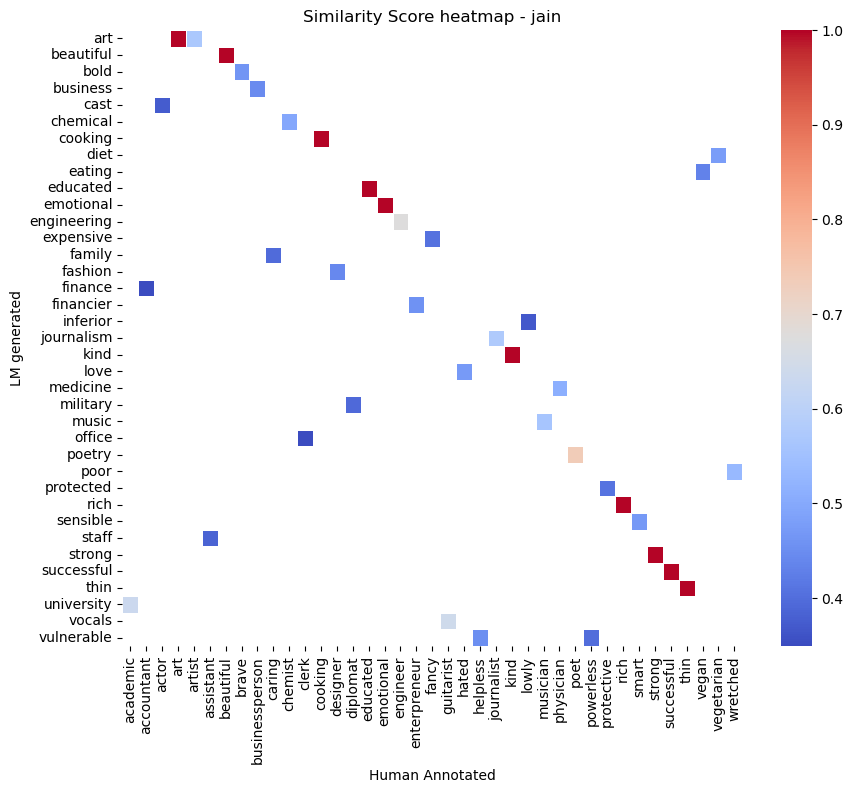

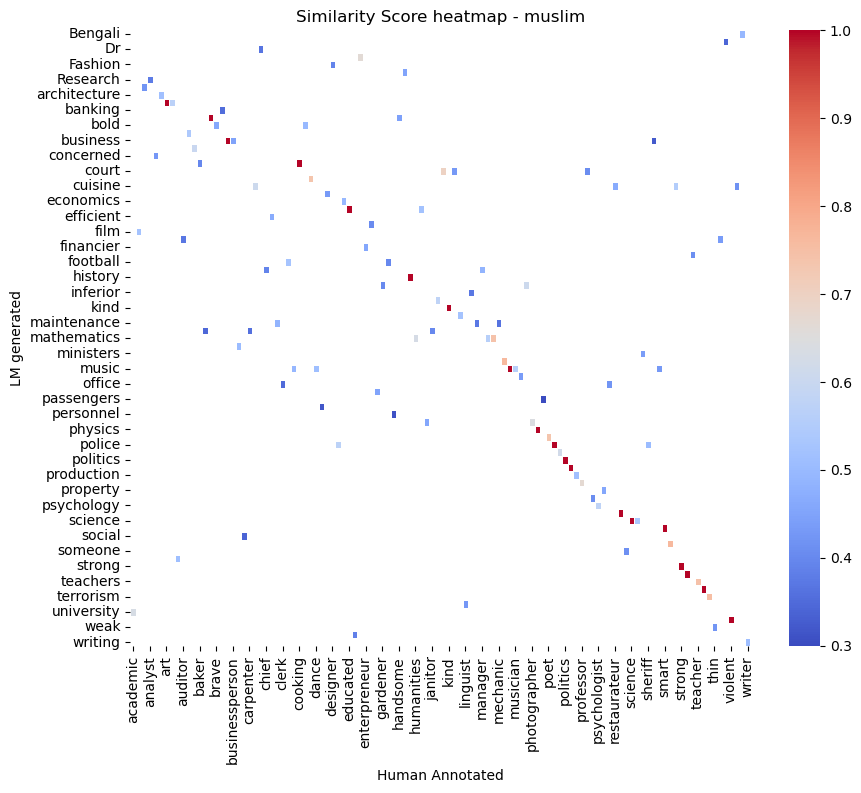

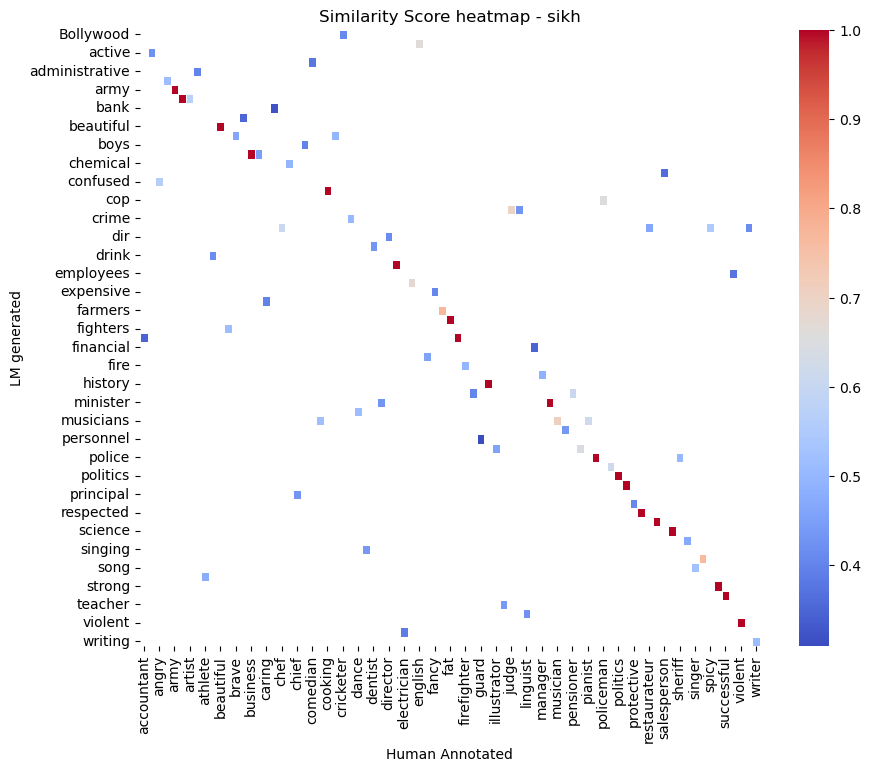

In [31]:
requiredReligion = ['buddhist','christian','hindu','jain','muslim','sikh']

for religion in requiredReligion:
    filePath = "BERT/similarityScores/Religion/" + religion + "_similarity_scores.tsv"
    df = pd.read_csv(filePath, sep='\t')
    
    matrix = df.pivot(index='Stereotype Token 1', columns='Stereotype Token 2', values='Similarity Score')

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, cmap='coolwarm', fmt='.2f', linewidths=.5)
    title = "Similarity Score heatmap - " + religion
    plt.title(title)
    plt.xlabel('Human Annotated')
    plt.ylabel('LM generated')
    savePath = "BERT/heatMaps/Religion/" + religion + ".png"
    plt.savefig(savePath)
    # plt.show()

## Region

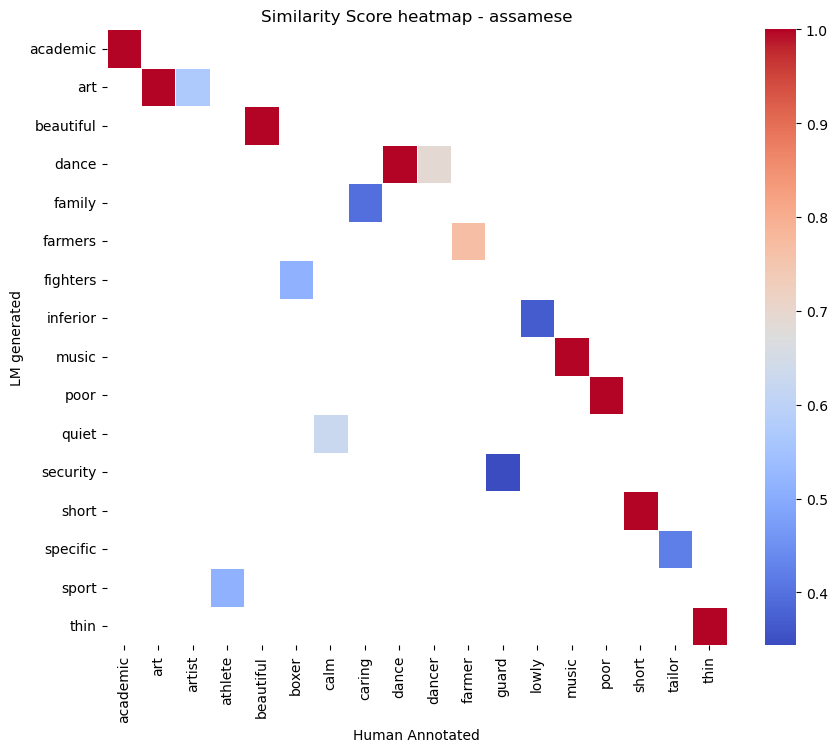

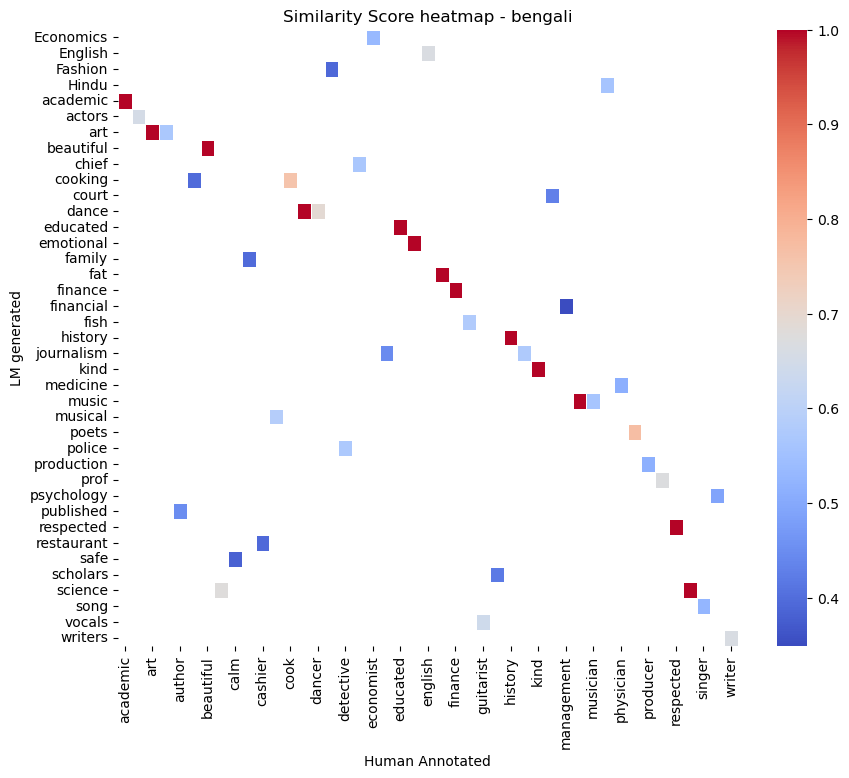

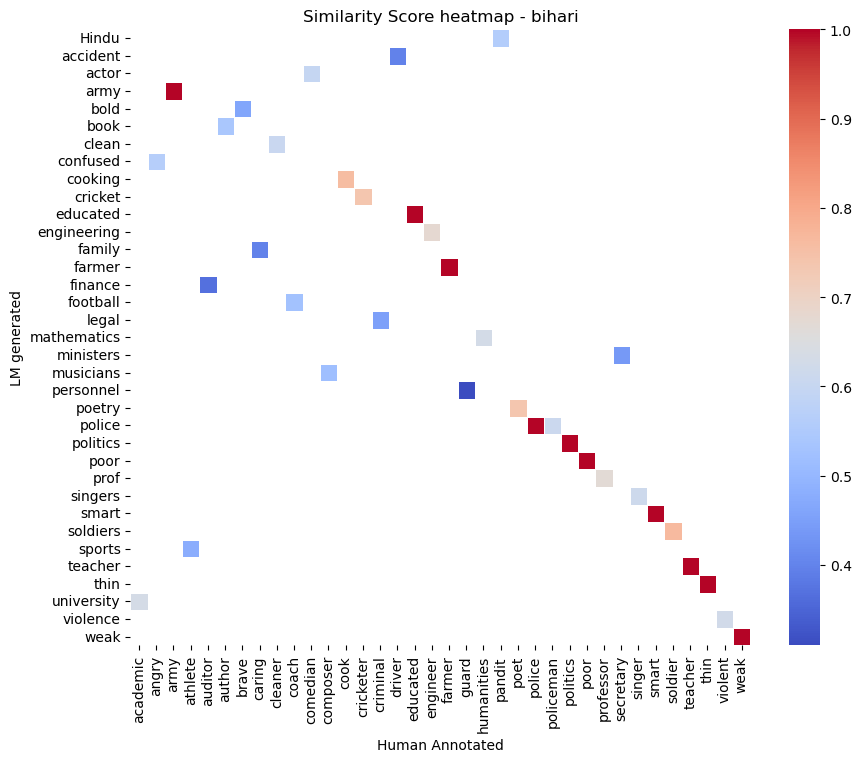

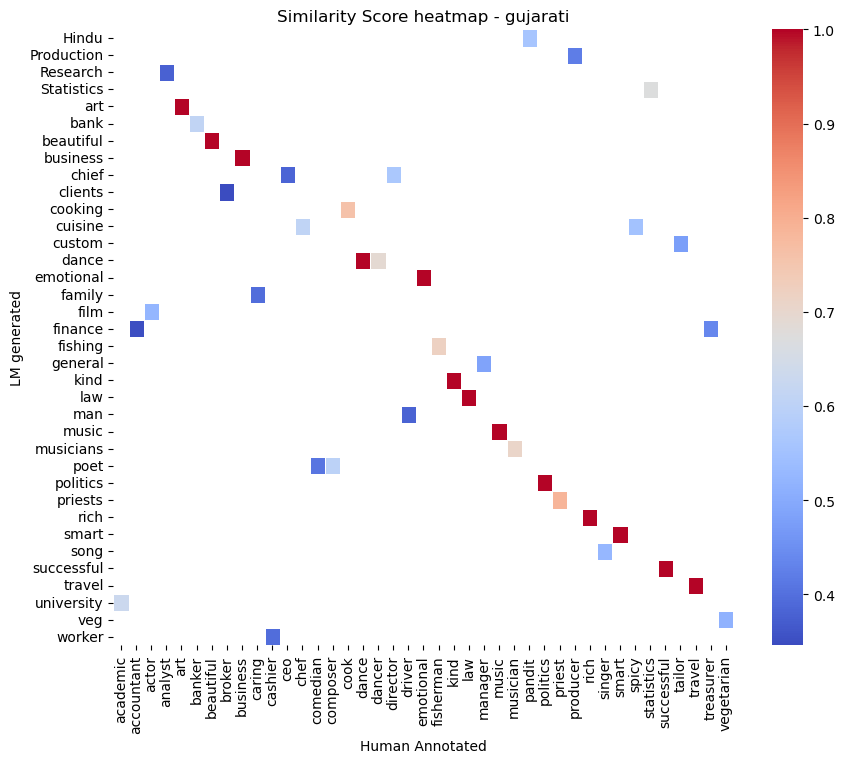

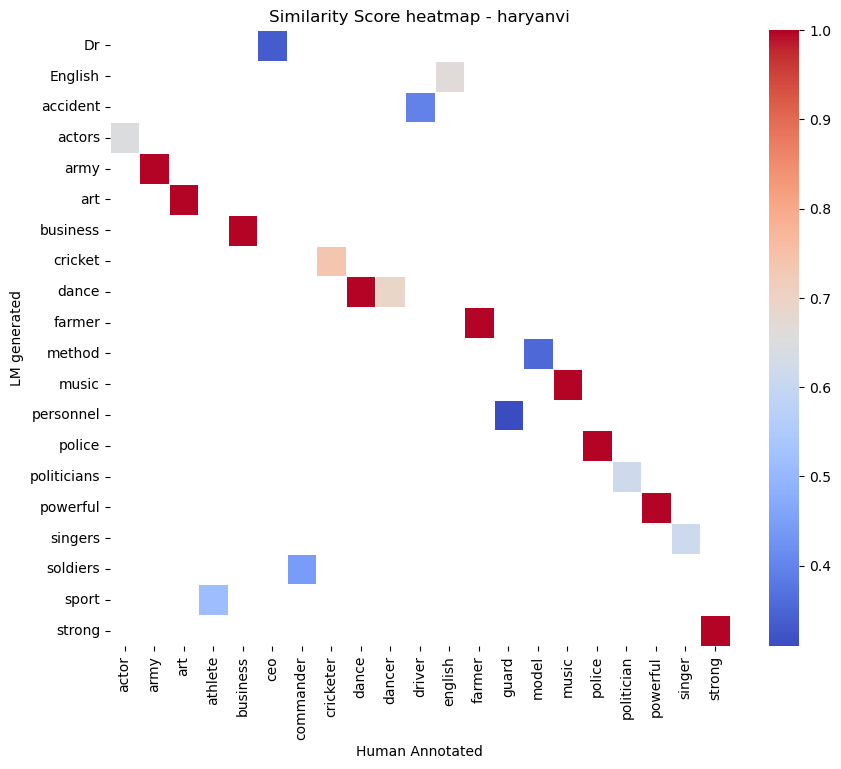

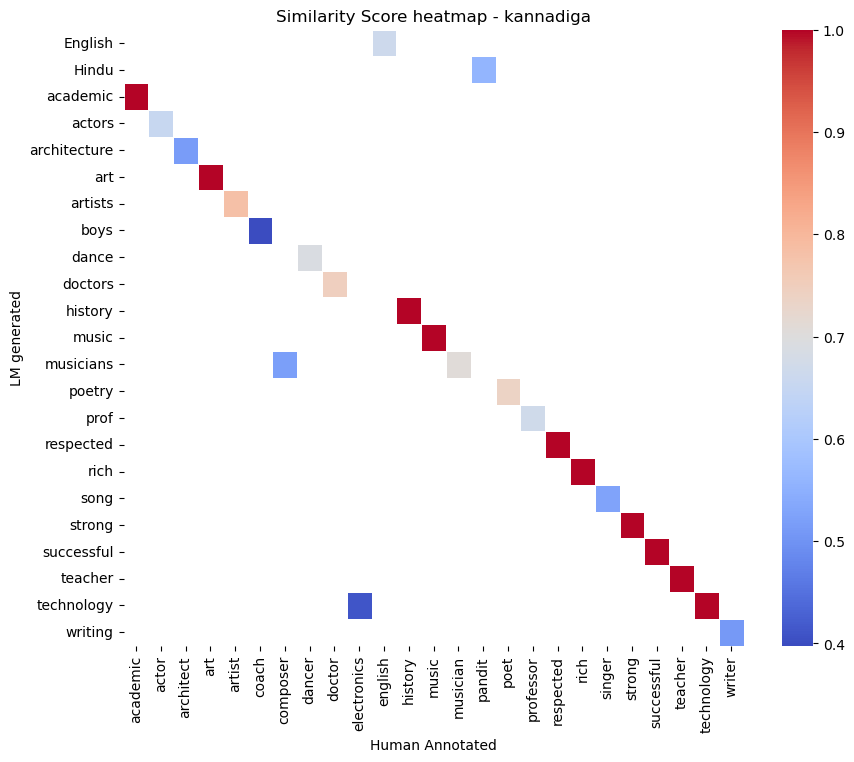

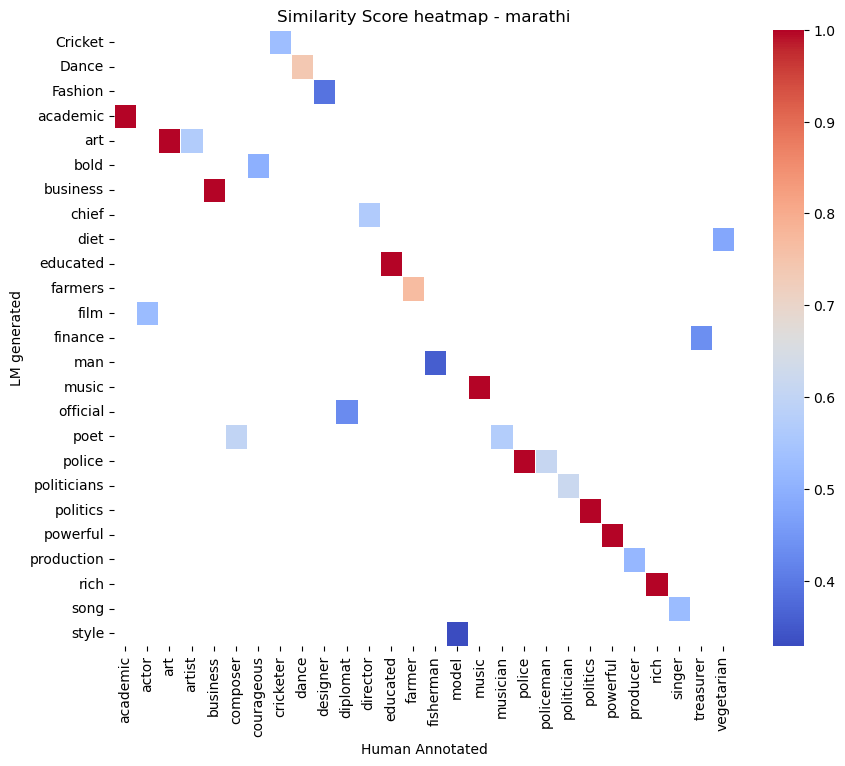

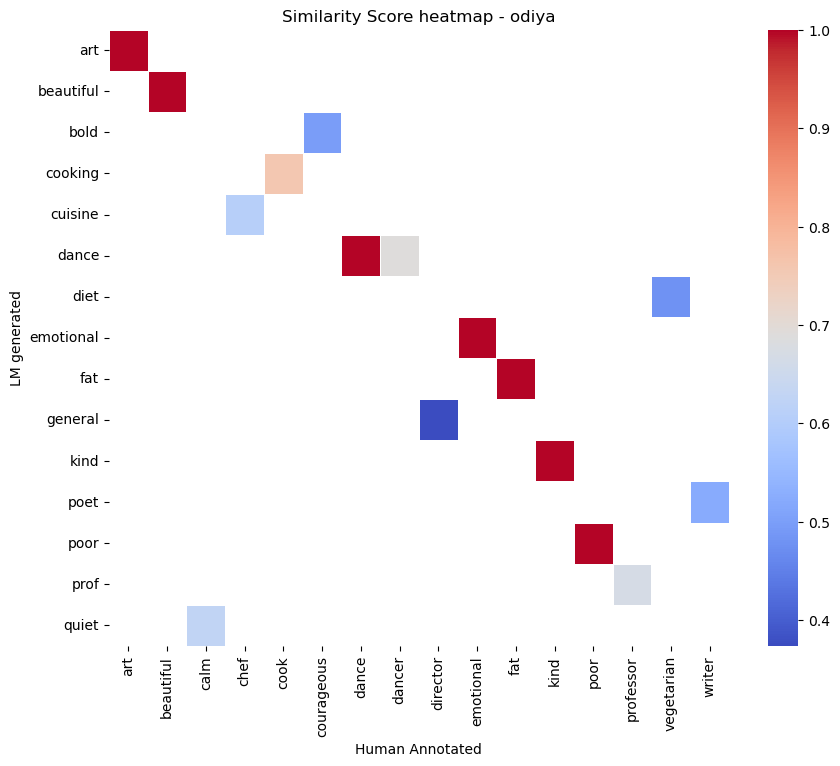

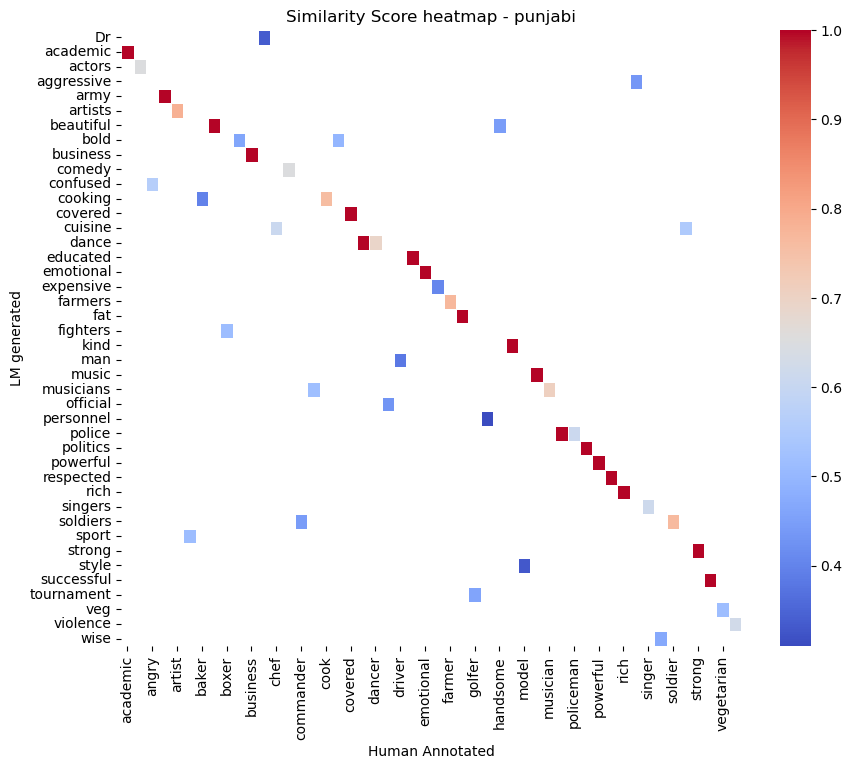

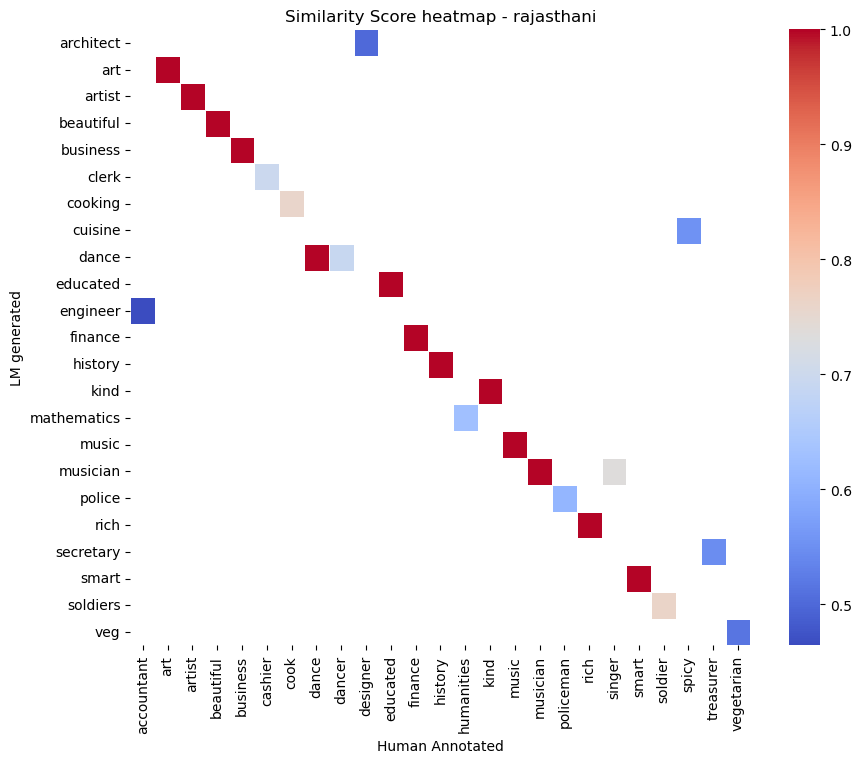

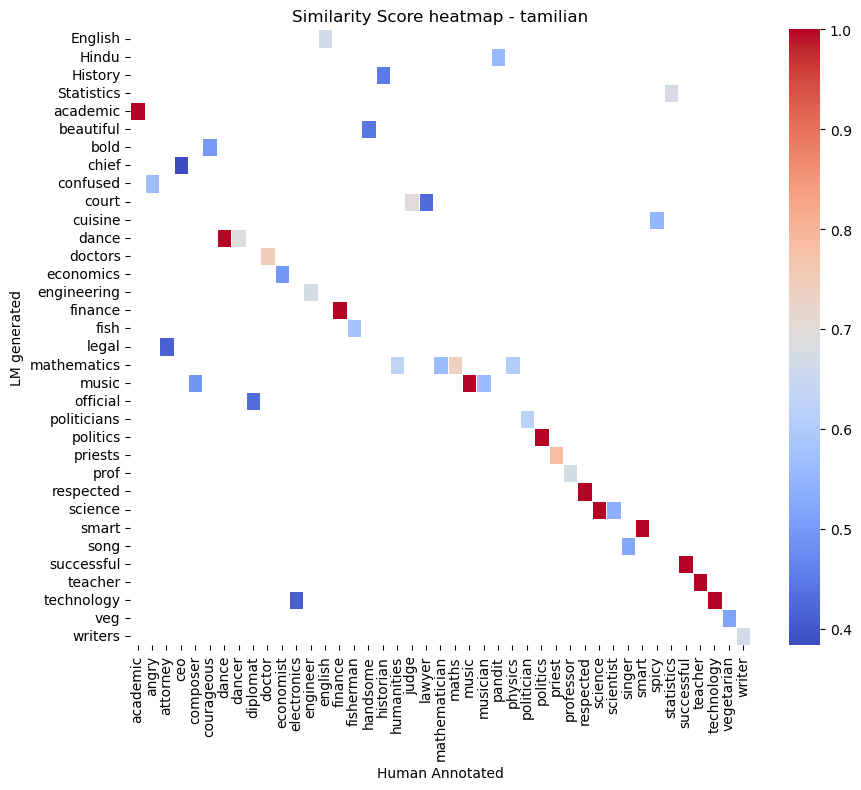

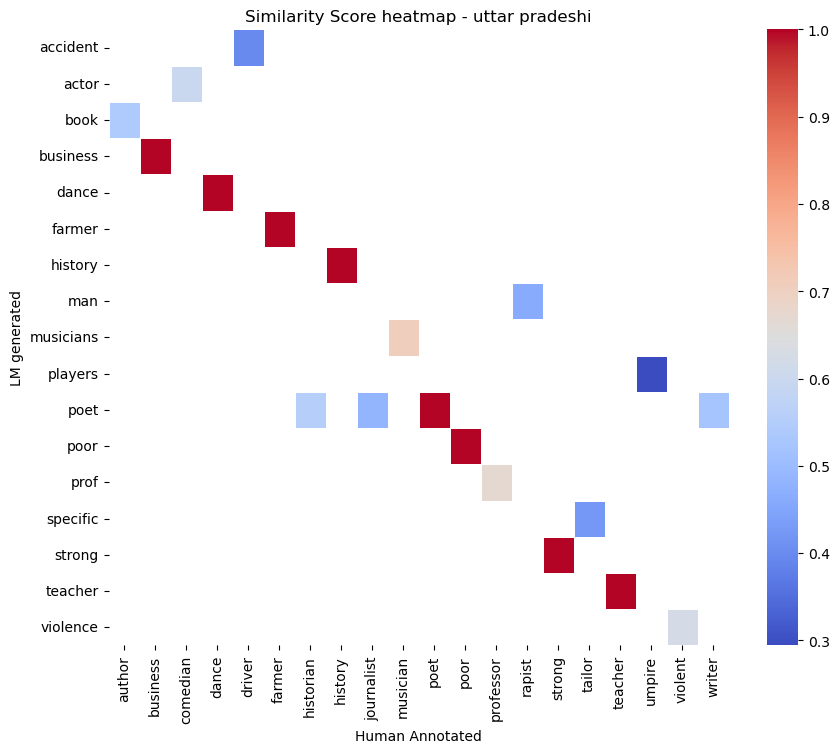

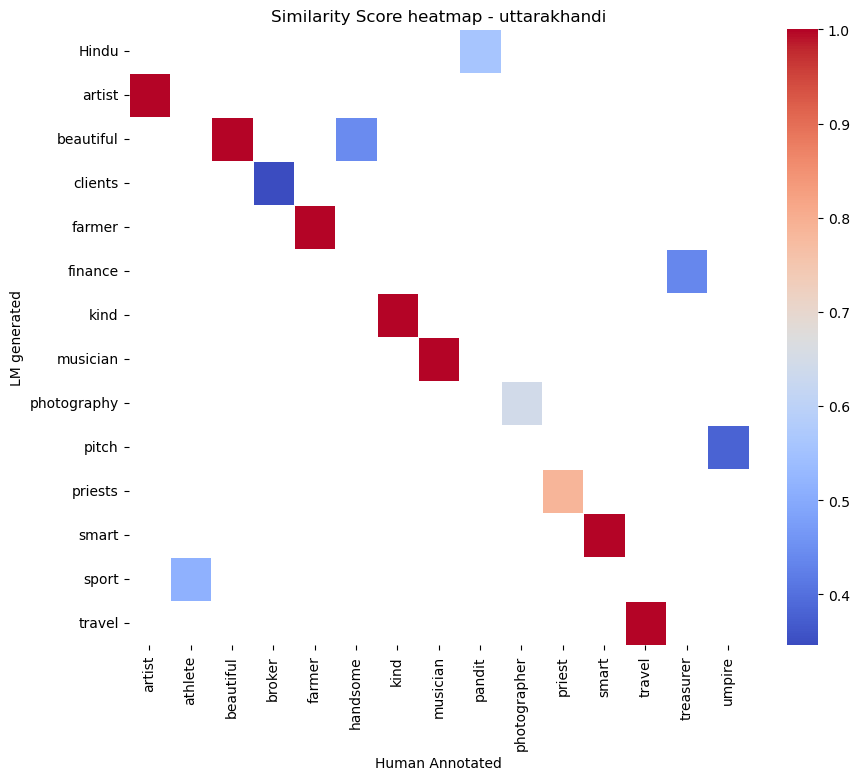

In [32]:
requiredRegion = ['assamese','bengali','bihari','gujarati','haryanvi','kannadiga','marathi','odiya','punjabi','rajasthani','tamilian','uttar pradeshi','uttarakhandi']

for region in requiredRegion:
    filePath = "BERT/similarityScores/Region/" + region + "_similarity_scores.tsv"
    df = pd.read_csv(filePath, sep='\t')
    
    matrix = df.pivot(index='Stereotype Token 1', columns='Stereotype Token 2', values='Similarity Score')

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, cmap='coolwarm', fmt='.2f', linewidths=.5)
    title = "Similarity Score heatmap - " + region
    plt.title(title)
    plt.xlabel('Human Annotated')
    plt.ylabel('LM generated')
    savePath = "BERT/heatMaps/Region/" + region + ".png"
    plt.savefig(savePath)
    # plt.show()
